In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ensemble_learning import Adaboost, accuracy

In [3]:
# read data
cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df_train = pd.read_csv('../data/bank/train.csv', names=cols)
df_test = pd.read_csv('../data/bank/test.csv', names=cols)

# process numeric input
medians = df_train.median()

for col in medians.index:
    df_train[col] = df_train[col].apply(lambda x: x > medians[col])
    df_test[col] = df_test[col].apply(lambda x: x > medians[col])
    
# process labels
label_dict={'yes': 1, 'no': -1}
df_train['y'] = df_train['y'].map(label_dict)
df_test['y'] = df_test['y'].map(label_dict)

X_train = df_train.drop(['y'], axis=1).values
y_train = df_train['y'].values

X_test = df_test.drop(['y'], axis=1).values
y_test = df_test['y'].values

In [4]:
%%time
model = Adaboost()
model.fit(X_train, y_train, T=500)

Wall time: 27.7 s


In [5]:
%%time
y_pred, i_pred, s_pred = model.predict(X_train, store_prev=True)

i_pred[i_pred < 0]=-1
i_pred[i_pred >= 0]=1

error_train = [1 - accuracy(i, y_train) for i in i_pred]
error_train_stump = [1 - accuracy(s, y_train) for s in s_pred]

Wall time: 19.8 s


In [6]:
%%time
y_pred, i_pred, s_pred = model.predict(X_test, store_prev=True)

i_pred[i_pred < 0]=-1
i_pred[i_pred >= 0]=1

error_test = [1 - accuracy(i, y_test) for i in i_pred]
error_train_stump = [1 - accuracy(s, y_test) for s in s_pred]

Wall time: 19.4 s


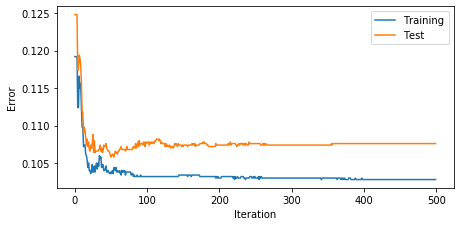

In [9]:
plt.figure(figsize=(6.5, 3.25))
plt.plot(error_train, label='Training')
plt.plot(error_test, label='Test')
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.legend()

plt.tight_layout()
plt.savefig('p_adaboost_total.png', bbox_inchex='tight')

plt.show()

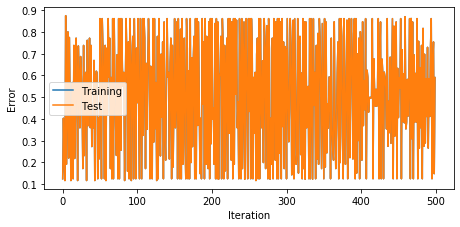

In [10]:
plt.figure(figsize=(6.5, 3.25))
plt.plot(error_train_stump, label='Training')
plt.plot(error_train_stump, label='Test')
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.legend()

plt.tight_layout()
plt.savefig('p_adaboost_single.png', bbox_inchex='tight')

plt.show()

In [ ]:
print('Adaboost Results T=500')
print(f"Training Error: {round(error_train[-1], 4)}")
print(f"Test Error:     {round(error_test[-1], 4)}")